In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data preparation

In [2]:
# data source: https://surfdrive.surf.nl/files/index.php/s/CZWfWQp3VKGKa8m
df = pd.read_csv('data_with_ports.csv.gz', sep='|', compression='gzip')

C:\Users\Hsin\.conda\envs\venvCyber\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (15,17,19,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# parse string to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['start_time'] = pd.to_datetime(df['start_time'], format='%Y-%m-%dT%H:%M:%S+09:00')
df['stop_time'] = pd.to_datetime(df['stop_time'], format='%Y-%m-%dT%H:%M:%S+09:00')

In [4]:
# remove reserved ips
reserved_ips = [
    "0.",       # software
    "10.",      # private network
    "100.",     # private network
    "169.254.", # subnet
    "172.",     # private network
    "192."      # private network
]

df = df[~(df.org.isna() & df.target_ip.str.startswith(tuple(reserved_ips)))]

In [5]:
# subset victim data of hosting providers
hp = df.loc[df.as_type == "hosting"]

In [6]:
from random import randint

hp.iloc[randint(0, len(hp))]

target_ip                                                    188.165.205.86
date                                                    2015-01-25 00:00:00
sensor_id                                                         sensor003
service                                                                 chg
start_time                                              2015-01-25 07:56:21
stop_time                                               2015-01-25 07:58:21
duration                                                                120
packets                                                                 625
raw_country                                                          France
raw_as                                                      AS16276 OVH SAS
raw_hostname                                     ns323095.ip-188-165-205.eu
udp_port_list                                                          [80]
pyasn_as                                                              16276
pyasn_as_bgp

In [7]:
# fix NaNs in `regions` data for victims that reside in United States and Canada
hp.loc[hp.raw_country.str.contains("United States|Cananda"), "region"] = "NA" # NA = North America

C:\Users\Hsin\.conda\envs\venvCyber\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [8]:
# victim org         = org
# size of victims    = org_ipsize_seen
# type of victim     = org_tag
# country victim     = raw_country
# network hygiene    = count_attacks_2014
# dependent variable = count_attacks

orgs = (hp.groupby(by=["org", "org_ipsize_seen", "org_tag", "raw_country", "region", "year"])
          .size().unstack().add_prefix("count_attack_")
          .fillna(0))

orgs.reset_index(inplace=True)
orgs.columns = orgs.columns.tolist()

orgs["count_attack"] = orgs.filter(regex="^count_attack").sum(axis=1)
orgs["count_attack_norm"] = orgs.count_attack / orgs.org_ipsize_seen

orgs.raw_country = orgs.raw_country.apply(lambda s: s.replace("<comma>", ","))

# remove companies that received just 1 attack, as we assume the first attack was only a trial
orgs = orgs[orgs.count_attack > 1]

In [9]:
orgs.to_csv("orgs.csv")

In [10]:
orgs

,org,org_ipsize_seen,org_tag,raw_country,region,count_attack_2014,count_attack_2015,count_attack,count_attack_norm
0,1&1 Internet,73813.0,hosting,Germany,WE,0.0,4.0,4.0,0.000054
1,1&1 Internet,73813.0,hosting,United States,NA,189.0,634.0,823.0,0.011150
2,1&1 Internet AG,181901.0,hosting,Germany,WE,539.0,2135.0,2674.0,0.014700
3,104319 Jays Webworks,5.0,hosting,United States,NA,2.0,0.0,2.0,0.400000
4,10Hosting,109.0,hosting,United States,NA,0.0,413.0,413.0,3.788991
...,...,...,...,...,...,...,...,...,...
996,webcode ltd,37.0,hosting,United States,NA,0.0,20.0,20.0,0.540541
997,webserver-a-rackshack.directi.com,45.0,hosting,United States,NA,1.0,118.0,119.0,2.644444
998,webserverwelcome.com,16.0,hosting,United States,NA,1.0,4.0,5.0,0.312500
999,xfreesoft,5.0,hosting,United States,NA,11.0,18.0,29.0,5.800000


## Visualisation

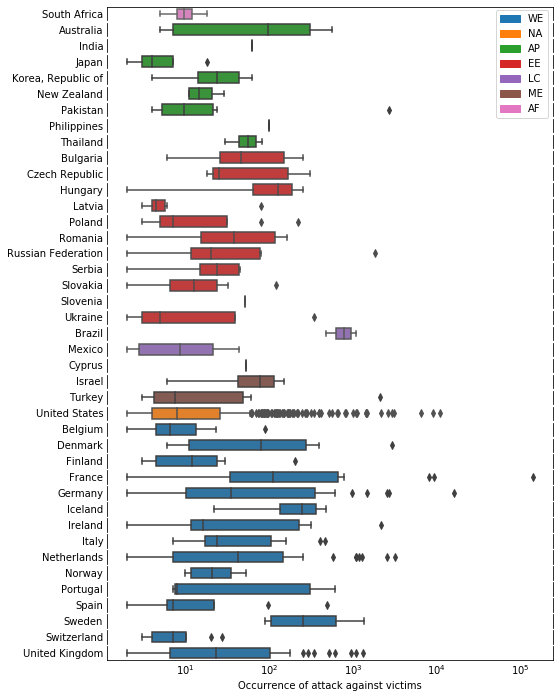

In [11]:
import matplotlib.patches as mpatches

# color the boxplots per region
regions = orgs.region.unique()
raw_countries = orgs.sort_values(by=["region", "raw_country"]).raw_country.unique()
colors = {regions[i] : sns.color_palette(n_colors=len(regions))[i] for i in range(len(regions))}

# plot per country
fig, ax = plt.subplots(len(raw_countries), figsize=(8,12), sharex=True)

for i in range(len(raw_countries)):
    region = orgs.region[orgs.raw_country == raw_countries[i]].values[0]
    sns.boxplot(x="count_attack", y="raw_country", orient="h", color=colors[region],
                data=orgs.sort_values(by=["region", "raw_country"]).loc[orgs.raw_country == raw_countries[i]], ax=ax[i])  
    
    # formatting axis
    ax[i].set_ylabel("")
    ax[i].set_xlabel("")
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["bottom"].set_visible(False)
    ax[i].tick_params(axis='both', which='both', length=0)
    
ax[i].set(xscale="log")
ax[0].spines["top"].set_visible(True)
ax[i].spines["bottom"].set_visible(True)
ax[i].set_xlabel("Occurrence of attack against victims")
plt.legend(handles=[mpatches.Patch(color=colors[regions[i]], label=regions[i]) 
                    for i in range(len(regions))], bbox_to_anchor=(1., 1.2*len(raw_countries)))

fig.savefig("images/attack-by-country.png")